### K-mean clustering of 5x5 image patches of MNIST dataset 

MNIST dataset contains 28x28 hand-written digits. Please extract 5x5 patches from 28x28 images, and there are more than 20 million such image patches. Of course, a majority of these image patches will be blank. You can discard these blank patches and focus on the rest ones, and do a K-mean clustering with these small image patches.

Please analyze the change of the learned clusters when you increase K from 100 – 10,000 (or even more). You can also analyze how well you can reconstruct a 5x5 MNIST patch by your learned dictionary (clusters). There are some interesting questions: 1) How many clusters do you need in order to cover the whole patch space? What are these clusters and do they have any interpretable meanings? How is one digit made from these clusters? These questions are just some example questions, and you are in charge of what is interesting to you in this weird image patch space.

 

One useful trick in this experiment may be that you can normalize your patch vector to unit norm, then your clusters can also be normalized, and the Euclidean distance is equivalent to sqrt(2-2<feature vector, image patch vector>). Of course, this will create issue with all blank patch, which needs additional care.

 

If you have a group, each one in the group can submit the same report. When you submit the report, please acknowledge the detail contribution from each member. 

In [2]:
import numpy as np
import torch
import torchvision.datasets as datasets
from matplotlib import pyplot as plt
from tqdm import tqdm
import gzip

In [2]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist = mnist_testset + mnist_trainset

100%|██████████| 9.91M/9.91M [00:00<00:00, 10.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 469kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.85MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.23MB/s]


In [ ]:
# split into patches (parallel over images)
import os
from joblib import Parallel, delayed


def extract_patches(img, patch_size=5, img_size=28):
    img = torch.tensor(np.array(img))
    local = []
    for i in range(img_size - patch_size + 1):
        for j in range(img_size - patch_size + 1):
            patch = img[i:i+patch_size, j:j+patch_size]
            if not (patch == 0).all():
                local.append(patch)
    return local


patches = []
patch_size = 5
img_size = 28
n_jobs = min(80, os.cpu_count() or 1)

patches_nested = Parallel(n_jobs=n_jobs, prefer="processes")(
    delayed(extract_patches)(img, patch_size, img_size) for img, label in tqdm(mnist)
)
# flatten once to avoid repeated list concatenation
patches = [p for sub in patches_nested for p in sub]

patches_t = torch.stack(patches)
with gzip.open('./data/patches.pt.gz', 'wb') as f:
    torch.save(patches_t, f)



  0%|          | 0/70000 [00:00<?, ?it/s]

  4%|▍         | 2800/70000 [02:04<47:20, 23.66it/s]

KeyboardInterrupt: 

  4%|▍         | 2800/70000 [02:20<47:20, 23.66it/s]

In [ ]:
# split into patches
patches = []
patch_size = 5
img_size = 28
for img, label in tqdm(mnist):
    img = torch.tensor(np.array(img))
    for i in range(img_size - patch_size + 1):
        for j in range(img_size - patch_size + 1):
            patch = img[i:i+patch_size, j:j+patch_size]
            if not (patch == 0).all():
                patches.append(patch)

patches_t = torch.stack(patches)
with gzip.open('./data/patches.pt.gz', 'wb') as f:
    torch.save(patches_t, f)

In [3]:
with gzip.open('./data/patches.pt.gz', 'rb') as f:
    patches = torch.load(f)

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import joblib

def preprocess_patches(patches):
    
    # flatten patches to (N,25)
    patch_vectors = patches.view(patches.shape[0], -1).numpy()
    
    # normalize patches
    patch_vectors = normalize(patch_vectors, norm='l2')
    return patch_vectors

def apply_kmeans_to_patches(patches, n_clusters=100, sample_size=None):
    """
    Apply k-means clustering to 5x5 image patches.
    
    Args:
        patches: torch tensor of shape (N, 5, 5) where N is number of patches
        n_clusters: number of clusters (K)
        normalize_patches: whether to normalize patches to unit norm
        sample_size: if not None, randomly sample this many patches for clustering
    
    Returns:
        kmeans: fitted KMeans object
        cluster_centers: cluster centers reshaped back to (n_clusters, 5, 5)
    """
    if sample_size is not None and sample_size < len(patches):
        # Randomly sample patches
        indices = np.random.choice(len(patches), sample_size, replace=False)
        patches = patches[indices]
    
    # Apply k-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(patches)
    
    # Reshape cluster centers back to (5, 5)
    #cluster_centers = kmeans.cluster_centers_.reshape(n_clusters, 5, 5)
    
    return kmeans

In [ ]:
# Apply k-means with K=100 on a sample of 10,000 patches
patch_vectors = preprocess_patches(patches)
for n_clusters in tqdm(np.arange(100, 10100, 100)):
    kmeans = apply_kmeans_to_patches(patch_vectors, n_clusters=n_clusters)
    joblib.dump(kmeans, f"kmeans_{n_clusters}.pkl")

ValueError: Type must be a sub-type of ndarray type

In [27]:
patch_vectors = patches.view(patches.shape[0], -1).numpy()
patch_vectors = normalize(patch_vectors, norm='l2')
prediction = kmeans_100.predict(patch_vectors)

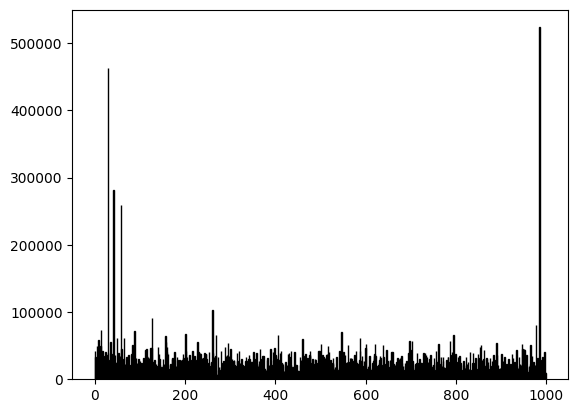

In [35]:
plt.hist(prediction, bins=1000, color='skyblue', edgecolor='black')
plt.show()

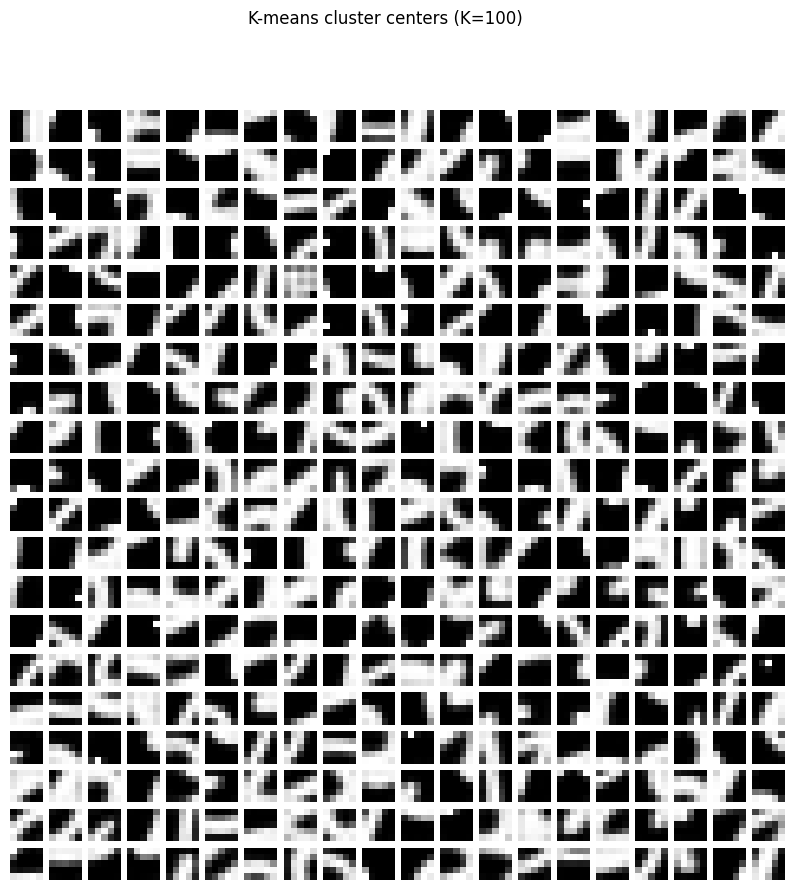

In [18]:
# Visualize some cluster centers
fig, axes = plt.subplots(20, 20, figsize=(10, 10))
for i in range(400):
    ax = axes[i//20, i%20]
    ax.imshow(centers_100[i], cmap='grey')
    ax.axis('off')
plt.suptitle('K-means cluster centers (K=100)')
plt.show()